In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 18 03:27:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [5]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random




from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD 



#embedding
from gensim.models import Word2Vec

# tqdm
from tqdm.notebook import tqdm

#tensorflow
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, Flatten,Dense
from tensorflow import keras
import tensorflow_addons as tfa
from keras import backend as K

#os
import os



In [9]:
train_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/train.json"
test_file_path = "/content/drive/MyDrive/SML_assign/comp90051-22-s2-authorship/test.json"

with open(train_file_path, 'r') as f:
    data = json.load(f)
df_train = pd.DataFrame(data)

with open(test_file_path, 'r') as f:
    data = json.load(f)
df_test = pd.DataFrame(data)

In [10]:
# Retrive the non-prolific author and prolific author index
non_prolific_author_index = []
prolific_author_index = []
for i,j in enumerate(df_train['authors']):
  sum = 0
  for k in j:
    if k < 100 and k >= 0:
      sum += 1
  if sum == 0:
    non_prolific_author_index.append(i)
  else:
    prolific_author_index.append(i)

df_non_prolifc_authors = df_train.drop(prolific_author_index)
df_prolific_authors = df_train.drop(non_prolific_author_index)

In [11]:
df_prolific_authors

,authors,year,abstract,venue,title
0,"[42, 13720, 36]",9,"[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...",20,"[41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1..."
1,"[1359, 15881, 45]",15,"[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...",2,"[1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3..."
3,[97],10,"[46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...",4,"[40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5..."
4,"[19617, 2]",10,"[37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...",9,"[38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,..."
9,"[9641, 44, 5623, 2]",18,"[1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...",0,"[1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160..."
...,...,...,...,...,...
25767,"[19974, 68, 8903]",1,"[40, 1542, 1691, 2449, 1535, 2855, 1549, 1755,...",23,"[1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359..."
25776,"[6353, 67, 3037, 15856, 13521]",10,"[40, 1542, 1691, 2907, 1540, 1535, 2121, 2431,...",10,"[53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3..."
25778,"[7686, 3810, 87, 7451]",16,"[2144, 1661, 2151, 1966, 3776, 4864, 1546, 219...",31,"[1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1..."
25781,"[14864, 92]",16,"[37, 1662, 33, 1814, 2036, 1692, 1553, 2333, 2...",0,"[46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152..."


In [12]:
# Retrieve the prolific author as label
# prolific_author_label = []
# non_prolific_author_label = []
# for i in df_prolific_authors['authors']:
#   prolific_author_label_each_instance = []
#   non_prolific_author_label_each_instance = []
#   for j in i:
#     if j >= 0 and j < 100:
#       prolific_author_label_each_instance.append(j)
#     else:
#       non_prolific_author_label_each_instance.append(j)
#   prolific_author_label.append(prolific_author_label_each_instance)
#   non_prolific_author_label.append(non_prolific_author_label_each_instance)


# df_prolific_authors['coauthors'] = non_prolific_author_label







In [14]:
selected_col_nums = round(200*12.5)
non_prolific_author_rows =[]

for i in range(selected_col_nums):
  non_prolific_author_rows.append(random.randint(0,18333))

df_selected_non_prolific_authors = df_non_prolifc_authors.iloc[non_prolific_author_rows]

df_selected_non_prolific_authors['coauthors'] = df_selected_non_prolific_authors['authors']
df_prolific_authors_25_non_prolific = pd.concat([df_selected_non_prolific_authors, df_prolific_authors], axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
total_label = []
for i in df_prolific_authors_25_non_prolific['authors']:
  label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      label_each_instance.append(j)
  total_label.append(label_each_instance)


In [16]:
total_label[2000]

[]

In [17]:
df_prolific_authors_25_non_prolific

,authors,year,abstract,venue,title,coauthors
3490,"[857, 4317, 1470]",18,"[40, 1542, 1691, 4926, 1615, 1966, 11, 3521, 1...",31,"[1615, 1966, 11, 3521, 1653, 19, 24, 1829, 174...","[857, 4317, 1470]"
7071,"[18246, 20107, 11174, 9929]",18,"[40, 1542, 1691, 3133, 1529, 4554, 1870, 1692,...",9,"[36, 2063, 1756, 1534, 1560, 1746, 1553, 1578,...","[18246, 20107, 11174, 9929]"
2008,"[14106, 14396]",18,"[47, 3357, 2752, 1647, 1542, 1530, 2194, 1631,...",217,"[47, 3357, 1549, 1571, 1852, 1533, 1530, 3795,...","[14106, 14396]"
13211,"[17472, 348, 1743, 5855, 17665]",9,"[40, 1798, 1853, 3589, 1532, 54, 2659, 6, 7, 1...",3,"[1650, 46, 1617, 2575, 1553, 37, 1791, 1714]","[17472, 348, 1743, 5855, 17665]"
914,"[19709, 963, 6889]",12,"[37, 2321, 1746, 1535, 3058, 1948, 1543, 4804,...",10,"[1872, 1538, 11, 1650, 4020, 3941, 1553, 4728,...","[19709, 963, 6889]"
...,...,...,...,...,...,...
25767,"[19974, 68, 8903]",1,"[40, 1542, 1691, 2449, 1535, 2855, 1549, 1755,...",23,"[1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359...",NaN
25776,"[6353, 67, 3037, 15856, 13521]",10,"[40, 1542, 1691, 2907, 1540, 1535, 2121, 2431,...",10,"[53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3...",NaN
25778,"[7686, 3810, 87, 7451]",16,"[2144, 1661, 2151, 1966, 3776, 4864, 1546, 219...",31,"[1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1...",NaN
25781,"[14864, 92]",16,"[37, 1662, 33, 1814, 2036, 1692, 1553, 2333, 2...",0,"[46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152...",NaN


In [18]:
#One-hot encoding the labels
multilable_binarizer = MultiLabelBinarizer()
ohe_prolific_labels = multilable_binarizer.fit_transform(total_label).astype('float')

In [20]:
ohe_prolific_labels[3000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Word2Vec

In [ ]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list


def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    total_list.append(per_instance)
  return total_list

# word to vec title model
string_title = convert_to_string(df_train['title'])
# Word2Vec
model_title = Word2Vec(string_title, min_count=1)
print(model_title)











Word2Vec(vocab=3444, size=100, alpha=0.025)


In [ ]:
type(df_train['title'][0])

list

In [ ]:
# word to vec coauthor model
string_coauthor = convert_to_string(df_train['authors'])

model_coauthor = Word2Vec(string_coauthor, min_count=1)
print(model_coauthor)

Word2Vec(vocab=20433, size=100, alpha=0.025)


In [ ]:
# word to vec abstract model
string_abstract = convert_to_string(df_train['abstract'])
# Word2Vec

model_abstract = Word2Vec(string_abstract, min_count=1,workers=4)
print(model_abstract)

Word2Vec(vocab=4845, size=100, alpha=0.025)


In [ ]:
string_abstract = convert_to_string(df_train['abstract'])

In [ ]:
print(model_abstract.similarity('1', '2'))

0.36800963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
model_abstract.wv['1']

array([-1.4585125e-02, -4.9507526e-01, -5.7288754e-01,  9.7955912e-01,
        2.6489365e-01, -1.2819332e-01,  2.8234828e-01,  2.6662230e-01,
       -1.1838480e-01,  1.8767974e-01,  5.3904080e-01,  7.6374042e-01,
       -3.8932884e-01, -3.2113820e-01, -1.7080314e-01,  1.6933297e+00,
        1.6835083e-01, -2.1455999e-02,  5.8086783e-02, -1.4915175e+00,
       -1.4530808e-01,  9.7644433e-02, -1.0873696e+00,  5.4729369e-02,
       -1.0224370e-01, -1.2627807e+00,  4.6923599e-01, -1.7403828e-01,
       -5.3643101e-01, -8.5532510e-01,  9.2136258e-01,  4.2069572e-01,
        4.4881791e-01, -1.0795524e-01,  6.3800983e-02, -3.8747343e-01,
       -4.6109316e-01, -3.5838169e-01,  7.3813371e-02, -5.5391479e-02,
        6.1840016e-01, -7.0899135e-01, -5.0981350e-02, -7.7799416e-01,
        1.2388848e+00,  3.8164669e-01,  1.3891292e-01, -5.0809234e-01,
        7.0885926e-01, -3.7789607e-01,  9.6797359e-01, -5.7110304e-01,
       -5.9669751e-01, -5.4595417e-01,  7.2006125e-04, -9.4210304e-02,
      

In [ ]:
from gensim.models.keyedvectors import KeyedVectors








#Tensorflow


In [21]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list


def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    if len(per_instance) == 0:
      per_instance.append(21246)
    total_list.append(per_instance)
  return total_list

In [22]:
num_author = convert_to_num(df_prolific_authors_25_non_prolific['coauthors'])
num_abstract = convert_to_num(df_prolific_authors_25_non_prolific['abstract'])
num_title = convert_to_num(df_prolific_authors_25_non_prolific['title'])

TypeError: ignored

In [ ]:
max_length_coauthor = max([len(i)for i in num_author])
max_length_abstract = max([len(i)for i in num_abstract])
max_length_title = max([len(i)for i in num_title])
print('max_length_coauthor' ,max_length_coauthor)
print('max_length_abstract ',max_length_abstract)
print('max_length_title ', max_length_title)

In [ ]:
min([len(i)for i in num_author])
  



1

In [ ]:
len(num_author)

9960

In [ ]:
max_length_coauthor = max([len(i)for i in num_author])

In [ ]:
padded_author = pad_sequences(num_author,truncating = 'post',maxlen = 100,padding ='post')
padded_title = pad_sequences(num_title,truncating = 'post',maxlen = 20,padding ='post')
padded_abastract = pad_sequences(num_abstract,truncating = 'post',maxlen = 64,padding ='post')

In [ ]:
embedding_dimension = 128
vocabulary_size_title_abstract = 5000
vocabulary_size_coauthor = 21247
max_length_abstract = 64
max_length_title = 20
max_length_coauthor = 100




In [ ]:
checkpoint_path = 'model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                              save_best_only=True,
                                              monitor = 'val_f1_score',
                                              mode='max')


# def create_model():
#   # abstract = layers.Embedding(input_dim = vocabulary_size_title_abstract, output_dim = embedding_dimension,mask_zero=True,input_length = max_length_abstract)
#   coauthor = layers.Embedding(input_dim = vocabulary_size_coauthor, output_dim = embedding_dimension,mask_zero=True,input_length = max_length_coauthor)
#   # title = layers.Embedding(input_dim = vocabulary_size_title_abstract, output_dim = embedding_dimension,input_length = max_length_title)
#   # concatenated_layer = layers.Concatenate(axis=1)([abstract, coauthor,title])
#   classification_model = tf.keras.Sequential([
#       coauthor,
#       layers.GlobalAveragePooling1D(),
#       layers.Dense(128, activation="relu"),
#       layers.Dropout(0.5),
#       # layers.Dense(128, activation="relu"),
#       # layers.Dropout(0.1),
#       layers.Dense(100,activation="sigmoid"),
      
#   ])
#   return classification_model

# model = create_model()
# model.summary()


inputs_abstract = keras.Input((max_length_abstract))
inputs_coauthor = keras.Input((max_length_coauthor))
inputs_title = keras.Input((max_length_title))

abstract_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_abstract, embeddings_regularizer= tf.keras.regularizers.L2(0.01))(inputs_abstract)
average_pool1 = layers.GlobalAveragePooling1D()(abstract_embed_layer)

coauthor_embed_layer = layers.Embedding(input_dim = vocabulary_size_coauthor,mask_zero=True, output_dim = embedding_dimension,input_length = max_length_coauthor)(inputs_coauthor)
average_pool2 = layers.GlobalAveragePooling1D()(coauthor_embed_layer)

title_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_title, embeddings_regularizer= tf.keras.regularizers.L2(0.01))(inputs_title)
average_pool3 = layers.GlobalAveragePooling1D()(title_embed_layer)

concatenated_layer = layers.Concatenate(axis = 1)([average_pool1, average_pool2,average_pool3])
# average_pool = layers.GlobalAveragePooling1D()(concatenated_layer)
x1 = layers.Dense(256, activation="relu")(concatenated_layer)
# x2 = layers.Dropout(0.1)(x1)
# x3 = layers.Dense(128, activation="relu") (x2)
x4 = layers.Dropout(0.5) (x1)
x5 = layers.Dense(100,activation="sigmoid") (x4)
model = keras.Model([inputs_abstract,inputs_coauthor,inputs_title],x5)
model.summary()

Model: "model_66"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_207 (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 input_208 (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 input_209 (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 embedding_254 (Embedding)      (None, 64, 128)      640000      ['input_207[0][0]']              
                                                                                           

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(padded_author,ohe_prolific_labels,test_size=0.0001,random_state=90051)

In [ ]:
metrics = tfa.metrics.F1Score(num_classes=100,threshold = 0.2, average='macro')
loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2,from_logits=False)
# metrics= ['categorical_accuracy']
# def calculating_class_weights(y_true):
#     from sklearn.utils.class_weight import compute_class_weight
#     number_dim = np.shape(y_true)[1]
#     weights = np.empty([number_dim, 2])
#     for i in range(number_dim):
#         weights[i] = compute_class_weight(class_weight ='balanced', classes = np.unique(y_true[:, i]), y = y_true[:, i])
#     return weights

# weights = calculating_class_weights(ohe_prolific_labels)
# # print(weights)
# def get_weighted_loss(weights):
#     def weighted_loss(y_true, y_pred):
#         return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
#     return weighted_loss

# metrics = tf.keras.metrics.TopKCategoricalAccuracy(k = 3)
loss = tf.keras.losses.BinaryFocalCrossentropy()
optimizer = optimizers.Adam(learning_rate =0.0005)
model.compile(loss= loss, optimizer= optimizer, metrics = metrics)
history = model.fit([padded_abastract,padded_author,padded_title],ohe_prolific_labels, epochs = 150, batch_size= 128,callbacks = [callback], validation_split=0.05,shuffle = True)


# history = model.fit(X_train,y_train, epochs = 20, batch_size= 32,callbacks = [callback], validation_data = (X_test,y_test))

Epoch 1/100
69/74 [==========================>...] - ETA: 0s - loss: 0.5800 - f1_score: 0.0218
Epoch 1: val_f1_score improved from -inf to 0.23836, saving model to model/cp.ckpt
74/74 [==============================] - 2s 13ms/step - loss: 0.5425 - f1_score: 0.0231 - val_loss: 0.0181 - val_f1_score: 0.2384
Epoch 2/100
70/74 [===========================>..] - ETA: 0s - loss: 0.0093 - f1_score: 0.1777
Epoch 2: val_f1_score improved from 0.23836 to 0.50885, saving model to model/cp.ckpt
74/74 [==============================] - 1s 10ms/step - loss: 0.0092 - f1_score: 0.1795 - val_loss: 0.0081 - val_f1_score: 0.5089
Epoch 3/100
68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - f1_score: 0.3430
Epoch 3: val_f1_score improved from 0.50885 to 0.59559, saving model to model/cp.ckpt
74/74 [==============================] - 1s 10ms/step - loss: 0.0046 - f1_score: 0.3429 - val_loss: 0.0075 - val_f1_score: 0.5956
Epoch 4/100
69/74 [==========================>...] - ETA: 0s - loss: 0

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(checkpoint_path)


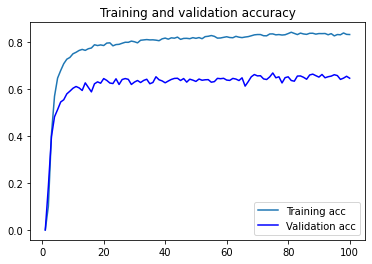

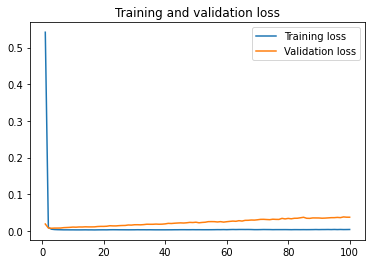

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
y_pred = model.predict(X_test)

ValueError: ignored

In [ ]:

# for i in range()
predicted_train = np.where(y_pred < 0.32, 0, 1)
f1_score(y_test, predicted_train, average='samples')

ValueError: ignored

## Test set

In [ ]:
test_num_author = convert_to_num(df_test['coauthors'])
test_padded_author = pad_sequences(test_num_author,truncating = 'post',maxlen = 100,padding ='post')

test_num_abstract = convert_to_num(df_test['abstract'])
test_padded_abstract = pad_sequences(test_num_abstract,truncating = 'post',maxlen = 64,padding ='post')

test_num_title = convert_to_num(df_test['title'])
test_padded_title = pad_sequences(test_num_title,truncating = 'post',maxlen = 20,padding ='post')

In [ ]:

y_pred = model.predict([test_padded_abstract,test_padded_author,test_padded_title])

# y_pred = model.predict(test_padded_author)

In [ ]:
y_pred[1]

array([0.04884207, 0.06637765, 0.16407244, 0.1514165 , 0.07605949,
       0.02360243, 0.0734454 , 0.02283827, 0.06977431, 0.09749418,
       0.05602984, 0.08805718, 0.1253327 , 0.01725597, 0.04327458,
       0.24340266, 0.03937146, 0.18710093, 0.04802784, 0.01526169,
       0.08206157, 0.0703341 , 0.11196993, 0.0287233 , 0.01881771,
       0.06248103, 0.06488086, 0.01136718, 0.05772107, 0.01554422,
       0.08330224, 0.05310168, 0.09021663, 0.0050108 , 0.02762326,
       0.12947452, 0.04978107, 0.01463542, 0.06101418, 0.01797094,
       0.03318889, 0.05427147, 0.02120473, 0.01450409, 0.00944582,
       0.02994598, 0.0036325 , 0.00273903, 0.07632797, 0.12672713,
       0.00789447, 0.04590845, 0.05995698, 0.05742054, 0.07655198,
       0.13852243, 0.01571916, 0.1459133 , 0.01561953, 0.11127421,
       0.05268427, 0.07033515, 0.18900241, 0.00110519, 0.05977865,
       0.09414211, 0.10250361, 0.02911145, 0.03907971, 0.11578773,
       0.03459211, 0.10684987, 0.12222959, 0.11964449, 0.09421

In [ ]:

prediction = np.where(y_pred < 0.23, 0, 1)

In [ ]:
prediction[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
predicted_list = [i.tolist() for i in prediction]
total_index_list = []
for i in predicted_list:
  index_list = []
  for j,k in enumerate(i):
    if k == 1:
        index_list.append(str(j))
  if len(index_list) != 0:
    total_index_list.append(index_list)
  else:
    total_index_list.append([str(-1)])

predicted_str = []
for i in total_index_list:
  a = ','.join(i)
  predicted_str.append(a)

In [ ]:

df_output = pd.DataFrame({'ID': list(range(800)),'Predict':predicted_str})
df_output.to_csv('predicted_result.csv',index = False)

In [ ]:
df_output['Predict'].values.tolist().count('-1') / 800

0.235

In [ ]:
df_output

,ID,Predict
0,0,92
1,1,15
2,2,31
3,3,23
4,4,"32,38"
...,...,...
795,795,54
796,796,97
797,797,13
798,798,84
